In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import json
import os
import pdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# ML Analysis of simulated outbreaks

This uses a RNN on the sequence of confimed clinical cases

## Read the data in

In [2]:
def load_files(path):

    flist = os.listdir(path)

    Cc = dict()
    Params = dict()

    for i, f in enumerate(flist):
        print("Loading", i, "of", len(flist))
        if "_Cc.json" in f:
            with open(os.path.join(path,f) ) as fp:
                Cc[f.replace("_Cc.json", "")] = json.load(fp)
            continue
        elif "_params.json" in f:
            with open(os.path.join(path,f) ) as fp:
                Params[f.replace("_params.json", "")] = json.load(fp)
            continue
        else:
            raise ValueError("File names must have either _Cc.json or _params.json")

    if not all([f in Params.keys() for f in Cc.keys()]):
        raise ValueError("Not all params and curves present")

    Cc_v = list()
    Params_v = list()
    for i in Cc.keys():
        Cc_v.append(Cc[i])
        Params_v.append(Params[i])

    return Params_v, Cc_v

Load the data and reshape

In [108]:
Params, Cc = load_files("sims/23_06_25")

# Pad the Cc vector with zeros so they are all the same length
max_vsize = max([len(x) for x in Cc])
[x.extend([0]*(max_vsize - len(x))) for x in Cc]
X = np.array(Cc)

## Pull the labels
y = pd.DataFrame(Params)[['BETA1', 'cm']]

## Pull the Beta0s
b0 = pd.DataFrame(Params)[['BETA0']]

Loading 0 of 800
Loading 1 of 800
Loading 2 of 800
Loading 3 of 800
Loading 4 of 800
Loading 5 of 800
Loading 6 of 800
Loading 7 of 800
Loading 8 of 800
Loading 9 of 800
Loading 10 of 800
Loading 11 of 800
Loading 12 of 800
Loading 13 of 800
Loading 14 of 800
Loading 15 of 800
Loading 16 of 800
Loading 17 of 800
Loading 18 of 800
Loading 19 of 800
Loading 20 of 800
Loading 21 of 800
Loading 22 of 800
Loading 23 of 800
Loading 24 of 800
Loading 25 of 800
Loading 26 of 800
Loading 27 of 800
Loading 28 of 800
Loading 29 of 800
Loading 30 of 800
Loading 31 of 800
Loading 32 of 800
Loading 33 of 800
Loading 34 of 800
Loading 35 of 800
Loading 36 of 800
Loading 37 of 800
Loading 38 of 800
Loading 39 of 800
Loading 40 of 800
Loading 41 of 800
Loading 42 of 800
Loading 43 of 800
Loading 44 of 800
Loading 45 of 800
Loading 46 of 800
Loading 47 of 800
Loading 48 of 800
Loading 49 of 800
Loading 50 of 800
Loading 51 of 800
Loading 52 of 800
Loading 53 of 800
Loading 54 of 800
Loading 55 of 800
Lo

Loading 746 of 800
Loading 747 of 800
Loading 748 of 800
Loading 749 of 800
Loading 750 of 800
Loading 751 of 800
Loading 752 of 800
Loading 753 of 800
Loading 754 of 800
Loading 755 of 800
Loading 756 of 800
Loading 757 of 800
Loading 758 of 800
Loading 759 of 800
Loading 760 of 800
Loading 761 of 800
Loading 762 of 800
Loading 763 of 800
Loading 764 of 800
Loading 765 of 800
Loading 766 of 800
Loading 767 of 800
Loading 768 of 800
Loading 769 of 800
Loading 770 of 800
Loading 771 of 800
Loading 772 of 800
Loading 773 of 800
Loading 774 of 800
Loading 775 of 800
Loading 776 of 800
Loading 777 of 800
Loading 778 of 800
Loading 779 of 800
Loading 780 of 800
Loading 781 of 800
Loading 782 of 800
Loading 783 of 800
Loading 784 of 800
Loading 785 of 800
Loading 786 of 800
Loading 787 of 800
Loading 788 of 800
Loading 789 of 800
Loading 790 of 800
Loading 791 of 800
Loading 792 of 800
Loading 793 of 800
Loading 794 of 800
Loading 795 of 800
Loading 796 of 800
Loading 797 of 800
Loading 798 

Test/Train split and encode the parameters

In [109]:
y = y.replace({'BETA1': {0.5: 'BETA1TRUE', 0: 'BETA1FALSE'}, 'cm': {0.5: 'CMTRUE', 0: 'CMFALSE'}})
y['y'] = y['BETA1'] + '_' + y['cm']
del y['BETA1']
del y['cm']

In [129]:
## Standardize the Cc data 
X = X/np.max(X)

In [110]:
## Convert to spectrograpm (from https://www.tensorflow.org/tutorials/audio/simple_audio#convert_waveforms_to_spectrograms)
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=7, frame_step=1)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

0.8276333789329686
tf.Tensor(
[[ 9.288734  -6.8247318e-06j -0.13191043-9.7522371e-02j
   0.7799835 -3.2697886e-01j ... -0.5002866 +4.8020956e-01j
   0.7799773 +3.2697532e-01j -0.13190876+9.7521886e-02j]
 [14.874231  -4.1797757e-06j  0.2349831 -2.6480165e-01j
  -0.43543476-3.4585968e-01j ... -0.6338158 +6.9148254e-01j
  -0.43543485+3.4585977e-01j  0.23498681+2.6479995e-01j]
 [10.498448  -6.7800283e-06j  0.6085276 +3.9162692e-01j
   0.9854623 -7.8291023e-01j ... -0.99812764+6.1165303e-01j
   0.9854628 +7.8290391e-01j  0.60853136-3.9161664e-01j]
 ...
 [ 7.231471  -3.6656857e-06j -0.79141957+1.1022203e-01j
   0.10725514+1.9820619e-02j ... -0.46804473-6.3960886e-01j
   0.10725135-1.9819288e-02j -0.79141444-1.1022243e-01j]
 [13.45908   -7.8380108e-06j -0.14652601+6.5800995e-01j
   1.8166822 +3.1330928e-02j ... -1.4825444 -1.7013247e-01j
   1.8166634 -3.1331953e-02j -0.14652139-6.5800649e-01j]
 [13.897214  -9.6857548e-06j -0.9921247 -8.4569700e-02j
  -0.21860138+4.8809493e-01j ... -0.64963615

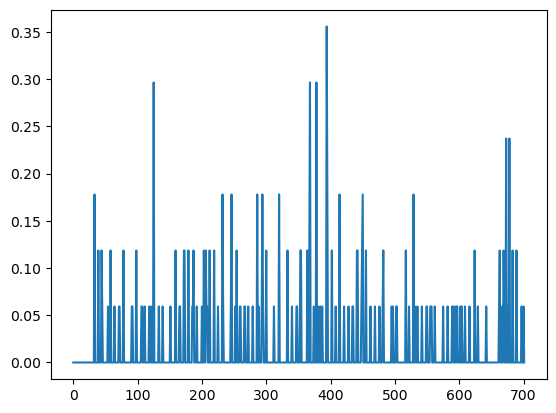

In [153]:
print(np.max(X[:,100:]))
print(tf.signal.fft(X))
plt.plot(X[80,:])

BETA1TRUE_CMTRUE


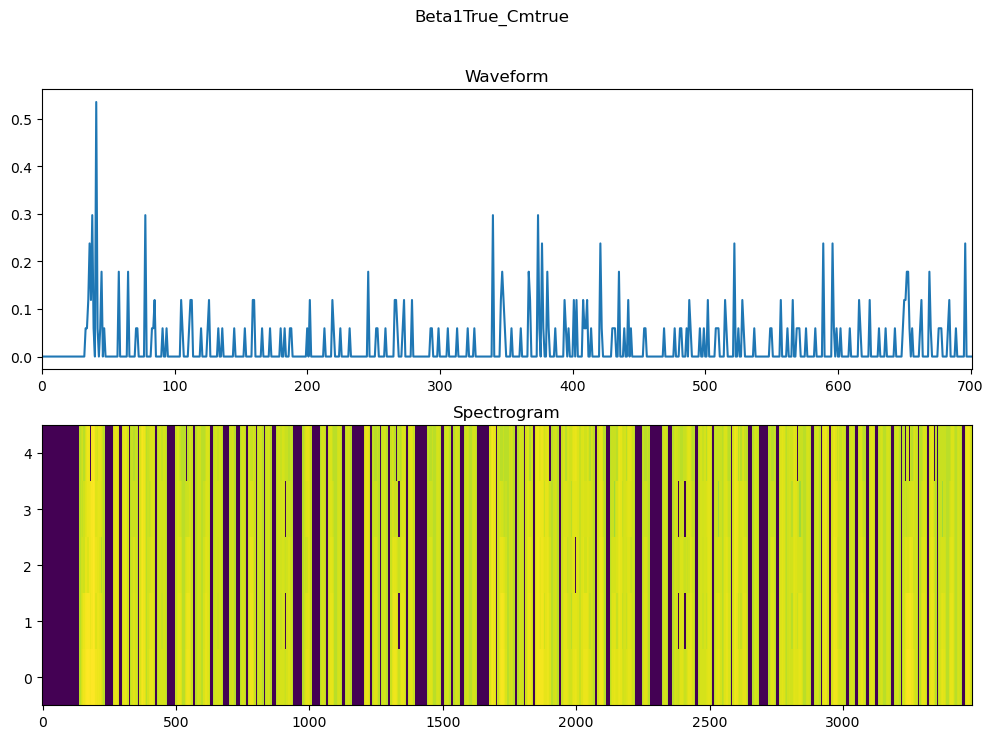

In [131]:
idx = 200 
waveform = X[idx,:]
spectrogram = get_spectrogram(waveform)
label = y['y'][idx]
print(label)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 701])

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [132]:
limit_to_one_year = False 

X_train_, X_test_, y_train_, y_test_, b0_train_, b0_test_ = train_test_split(
        X, y, b0, test_size=0.10, random_state=42)

if limit_to_one_year:
    X_train_ = X_train_[:,0:365]
    X_test_ = X_test_[:,0:365]
    
X_train = X_train_.reshape((X_train_.shape[0], X_train_.shape[1], 1))
X_test = X_test_.reshape((X_test_.shape[0], X_test_.shape[1], 1))

## One-hot encode the Params vec
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train_)
y_train = enc.transform(y_train_)
y_test = enc.transform(y_test_)

## Rename the B0 vec
b0_train = b0_train_
b0_test = b0_test_

/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [133]:
X_train.shape

(360, 702, 1)

In [134]:
y_train.shape

(360, 4)

In [135]:
b0_train.shape 

(360, 1)

In [136]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

Build the model

In [137]:
batch_size =128
input_dim = X_train.shape[1]
print(input_dim)
units = 64
output_size = y_train.shape[1]
print(output_size)

702
4


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 702, 1)]     0           []                               
                                                                                                  
 conv1d_28 (Conv1D)             (None, 702, 64)      1600        ['input_33[0][0]']               
                                                                                                  
 batch_normalization_28 (BatchN  (None, 702, 64)     256         ['conv1d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_28 (ReLU)                (None, 702, 64)      0           ['batch_normalization_28[0

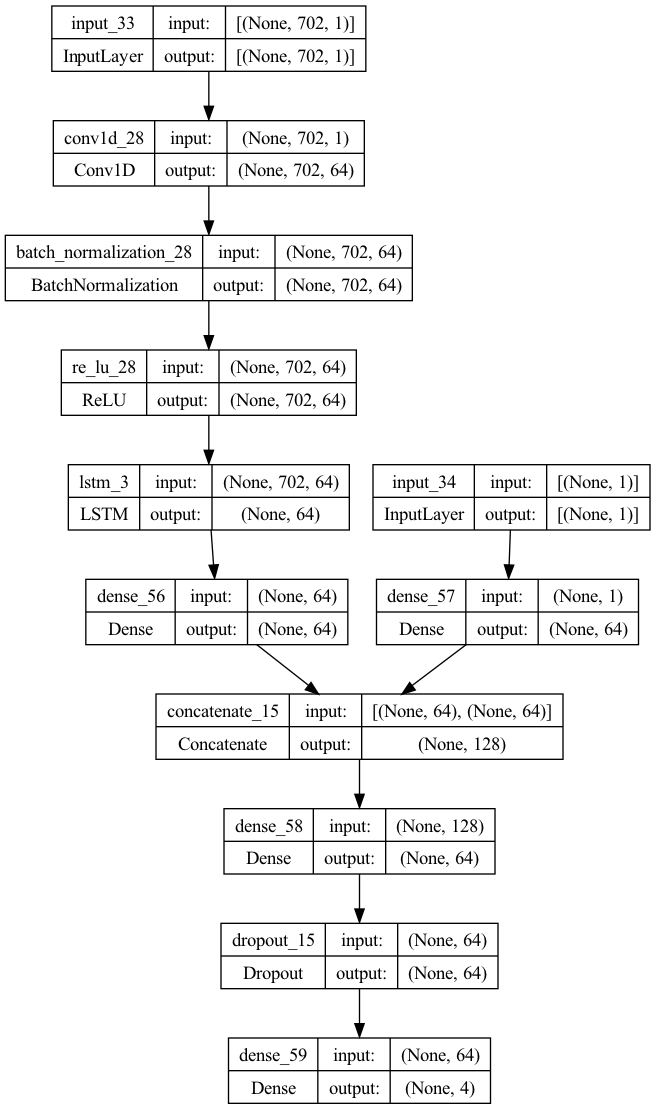

In [146]:
## Functional API with two inputs
Cc_input = layers.Input((input_dim, 1))
B0_input = layers.Input((1))

## Convolutional layer for CC
conv_layer = layers.Conv1D(filters=64,
                           kernel_size=24,
                           padding='same')(Cc_input)
conv_layer = layers.BatchNormalization()(conv_layer)
conv_layer = layers.ReLU()(conv_layer)
#conv_layer = layers.GlobalAveragePooling1D()(conv_layer)

## LSTM layer for Cc
lstm_layer = layers.LSTM(64)(conv_layer)
lstm_layer = layers.Dense(64)(lstm_layer)


## B0 dense layer
B0_layer = layers.Dense(64, activation = 'relu')(B0_input)

## Concatenate with the B0 input
concat_layer = layers.Concatenate()([B0_layer, lstm_layer])

## Hidden layer
hidden_layer = layers.Dense(64, activation = 'relu')(concat_layer)
hidden_layer = layers.Dropout(0.1)(hidden_layer)

## Output
output = layers.Dense(output_size, activation='softmax')(hidden_layer)

## Create model
model = keras.models.Model(inputs = [Cc_input, B0_input], outputs = output)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [139]:
if False:
    model = keras.models.Sequential([
        # layers.LSTM(256, return_sequences=True),
        # layers.SimpleRNN(256),
        # layers.Input((input_dim,1)),
        layers.Conv1D(filters=64,
                           kernel_size=24,
                           padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv1D(filters=64,
                           kernel_size=24,
                           padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv1D(filters=64,
                           kernel_size=24,
                           padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.GlobalAveragePooling1D(),

        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(output_size, activation='softmax')
    ])

In [147]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [150]:
tf.config.run_functions_eagerly(True)
history = model.fit(
    [X_train, b0_train], y_train,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.1,
    shuffle=True
)

## model.save('sims/classifier_model')

Epoch 1/50


/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - ETA: 0s - loss: 1.3674 - acc: 0.2994

/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 [==============================] - 4s 1s/step - loss: 1.3674 - acc: 0.2994 - val_loss: 1.3902 - val_acc: 0.1944
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 1.3588 - acc: 0.3179 - val_loss: 1.3892 - val_acc: 0.1944
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 1.3582 - acc: 0.3148 - val_loss: 1.3883 - val_acc: 0.1944
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 1.3543 - acc: 0.3241 - val_loss: 1.3873 - val_acc: 0.1944
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 1.3413 - acc: 0.3210 - val_loss: 1.3858 - val_acc: 0.1944
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 1.3397 - acc: 0.2840 - val_loss: 1.3853 - val_acc: 0.1944
Epoch 7/50
3/3 [==============================] - 4s 2s/step - loss: 1.3368 - acc: 0.3117 - val_loss: 1.3856 - val_acc: 0.1944
Epoch 8/50
3/3 [==============================] - 4s 1s/step - loss: 1.3312 - acc: 0.3457 - val_loss: 1.3855 - val_acc: 0.

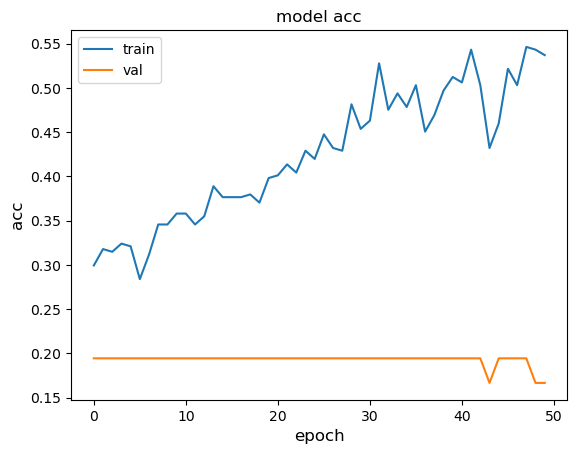

In [151]:
metric = "acc"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [152]:
y_pred = model.predict([X_test, b0_test])
print(y_pred)
y_pred = np.argmax(y_pred, axis = 1)
print("Accuracy:", np.mean(y_pred == np.argmax(y_test, axis=1)))

test_loss, test_acc = model.evaluate([X_test, b0_test], y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 1s 332ms/step
[[0.3047353  0.216936   0.28427267 0.19405599]
 [0.30189317 0.21902293 0.27660066 0.20248318]
 [0.31158373 0.21440257 0.2836558  0.19035788]
 [0.31301114 0.22092356 0.27007645 0.19598897]
 [0.29857412 0.23704794 0.27585158 0.18852639]
 [0.30082968 0.2231214  0.27622837 0.19982055]
 [0.3169616  0.21564761 0.27816597 0.18922481]
 [0.3117354  0.23160267 0.26106718 0.19559474]
 [0.30635723 0.22444302 0.27323297 0.19596674]
 [0.31633866 0.22831912 0.25960127 0.19574095]
 [0.29740104 0.2156554  0.28735256 0.19959104]
 [0.3024137  0.23424591 0.26113132 0.20220912]
 [0.2994029  0.21118061 0.29247475 0.19694175]
 [0.28760868 0.22774042 0.3066851  0.1779658 ]
 [0.29293394 0.20983388 0.30149895 0.19573325]
 [0.30672315 0.21902417 0.29459336 0.1796593 ]
 [0.31037325 0.22092111 0.2779938  0.19071181]
 [0.30050126 0.21473527 0.2850619  0.19970159]
 [0.30594862 0.21958928 0.27507234 0.19938979]
 [0.32059145 0.21813016 0.2717304  0.18954797]
 [0.309

/Users/eroubenoff/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 1s 334ms/step - loss: 1.4258 - acc: 0.2250
Test accuracy 0.22499999403953552
Test loss 1.4257662296295166
